In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import math  
import numpy as np
import pandas as pd

# SIR model

In [46]:
# Total population, N.
N = 7.8 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.6, 1/10

In [55]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [59]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma))
S, I, R = ret.T


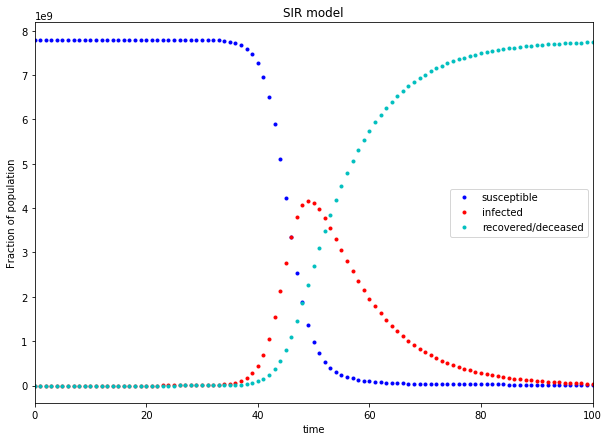

In [57]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b.', label='susceptible');
plt.plot(I, 'r.', label='infected');
plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()